### Prepare enviroment

In [14]:
%pip install -qU --upgrade boto3
%pip install -qU --upgrade sagemaker
%pip install xelatex 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com
ERROR: Could not find a version that satisfies the requirement xelatex (from versions: none)
ERROR: No matching distribution found for xelatex
Note: you may need to restart the kernel to use updated packages.


In [15]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from time import gmtime, strftime

### Setup Roles

In [16]:
role = get_execution_role()
sess = sagemaker.Session() 
region = sess.boto_session.region_name
bucket = sess.default_bucket()
print("The role is ", role)
print("The session is ", sess)
print("The region is ", region)
print("The bucket is ", bucket)

The role is  arn:aws:iam::801678843471:role/LabRole
The session is  <sagemaker.session.Session object at 0x7ff4b3e99480>
The region is  us-east-1
The bucket is  sagemaker-us-east-1-801678843471


### Load in Dataset

In [17]:
wine_df = pd.read_csv('winequality-red.csv', delimiter=';')

In [18]:
wine_df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


### Since Linear Learner assumes first collumn is target, we need to move quality be the first column

In [19]:
columns = wine_df.columns.tolist()
new_columns = columns[-1:] + columns[:-1]
wine_df = wine_df[new_columns]
wine_df.head()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4
1,5,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8
2,5,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8
3,6,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8
4,5,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4


In [20]:
# Check for missing values
wine_df.isnull().sum()

quality                 0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
dtype: int64

In [21]:
# Describe
wine_df.corr()

,quality,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
quality,1.000000,0.124052,-0.390558,0.226373,0.013732,-0.128907,-0.050656,-0.185100,-0.174919,-0.057731,0.251397,0.476166
fixed acidity,0.124052,1.000000,-0.256131,0.671703,0.114777,0.093705,-0.153794,-0.113181,0.668047,-0.682978,0.183006,-0.061668
volatile acidity,-0.390558,-0.256131,1.000000,-0.552496,0.001918,0.061298,-0.010504,0.076470,0.022026,0.234937,-0.260987,-0.202288
citric acid,0.226373,0.671703,-0.552496,1.000000,0.143577,0.203823,-0.060978,0.035533,0.364947,-0.541904,0.312770,0.109903
residual sugar,0.013732,0.114777,0.001918,0.143577,1.000000,0.055610,0.187049,0.203028,0.355283,-0.085652,0.005527,0.042075
chlorides,-0.128907,0.093705,0.061298,0.203823,0.055610,1.000000,0.005562,0.047400,0.200632,-0.265026,0.371260,-0.221141
free sulfur dioxide,-0.050656,-0.153794,-0.010504,-0.060978,0.187049,0.005562,1.000000,0.667666,-0.021946,0.070377,0.051658,-0.069408
total sulfur dioxide,-0.185100,-0.113181,0.076470,0.035533,0.203028,0.047400,0.667666,1.000000,0.071269,-0.066495,0.042947,-0.205654
density,-0.174919,0.668047,0.022026,0.364947,0.355283,0.200632,-0.021946,0.071269,1.000000,-0.341699,0.148506,-0.496180
pH,-0.057731,-0.682978,0.234937,-0.541904,-0.085652,-0.265026,0.070377,-0.066495,-0.341699,1.000000,-0.196648,0.205633


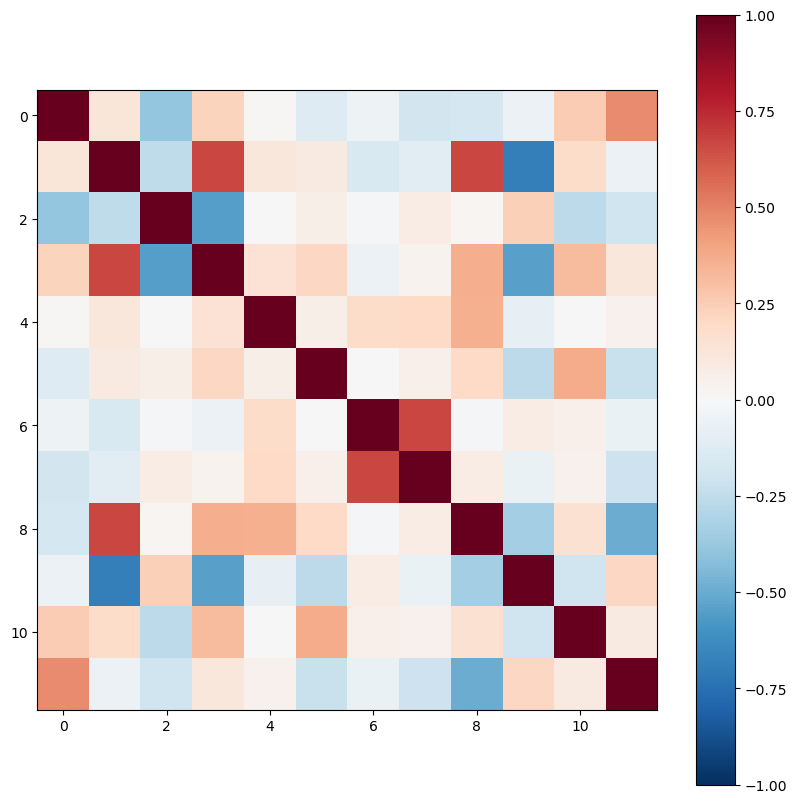

In [22]:
# matplot heatmap
fig, ax = plt.subplots(figsize=(10,10))
im = ax.imshow(wine_df.corr(), cmap='RdBu_r', vmin=-1, vmax=1)
fig.colorbar(im, ax=ax)

### Split the data into train and testing sets

In [23]:
# Split the data into train and test sets (80% training, 20% test)
train_data, test_data = train_test_split(wine_df, test_size=0.2)

# convert df to csv
train_data.to_csv('train.csv', index=False, header=False)
test_data.to_csv('test.csv', index=False, header=False)

In [24]:
# copy to s3

prefix = 'wine-quality'
training_input_path = sess.upload_data( path='train.csv', key_prefix=prefix + '/input/train') 
testing_input_path = sess.upload_data( path='test.csv', key_prefix=prefix + '/input/test')
output_path = 's3://{}/{}/output'.format(bucket, prefix)
print(training_input_path)
print(testing_input_path)
print(output_path)

s3://sagemaker-us-east-1-801678843471/wine-quality/input/train/train.csv
s3://sagemaker-us-east-1-801678843471/wine-quality/input/test/test.csv
s3://sagemaker-us-east-1-801678843471/wine-quality/output


### Train

In [25]:
from sagemaker.image_uris import retrieve

container = retrieve('linear-learner', region)

In [26]:
# Estimator

from sagemaker.estimator import Estimator 
ll_estimator = Estimator(container, 
                         role=role, 
                         instance_count=1, 
                         instance_type='ml.c4.xlarge', 
                         output_path=output_path)


In [27]:
# set multiclass classifier hyperparameters

ll_estimator.set_hyperparameters(predictor_type='multiclass_classifier',
                                num_classes=9)

In [28]:
# create a channel from the s3 data source and the file system
from sagemaker import TrainingInput

training_data_channel = TrainingInput( s3_data=training_input_path, content_type='text/csv') 
testing_data_channel = TrainingInput( s3_data=testing_input_path,   content_type='text/csv')

### Find best hyperparameters

In [29]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hypertuner = HyperparameterTuner(ll_estimator, 
                                 objective_metric_name = 'test:multiclass_accuracy',
                                 hyperparameter_ranges = {
                                 'learning_rate' : ContinuousParameter(0.01, 0.1),
                                 'mini_batch_size': CategoricalParameter([32,64,128,256,512])},
                                 objective_type = 'Maximize',
                                 metric_definitions = [{'Name': 'test:multiclass_accuracy', 'Regex': 'loss (\S+)'}],
                                 max_jobs=10, 
                                 max_parallel_jobs=1
                                 )

In [30]:
hypertuner.fit( {'train': training_data_channel, 'test': testing_data_channel})

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config
No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


..................................................................................................................................!


In [31]:
print("Best hyerparameter tuning job:{}".format(hypertuner.best_training_job()))
print("Best parameters found={}".format(hypertuner.best_estimator().hyperparameters()))

Best hyerparameter tuning job:linear-learner-230208-2201-009-be1e97a6

2023-02-08 22:12:11 Starting - Found matching resource for reuse
2023-02-08 22:12:11 Downloading - Downloading input data
2023-02-08 22:12:11 Training - Training image download completed. Training in progress.
2023-02-08 22:12:11 Uploading - Uploading generated training model
2023-02-08 22:12:11 Completed - Resource reused by training job: linear-learner-230208-2201-010-1caa297f
Best parameters found={'_tuning_objective_metric': 'test:multiclass_accuracy', 'learning_rate': '0.08664922418647995', 'mini_batch_size': '128', 'num_classes': '9', 'predictor_type': 'multiclass_classifier'}


### Train Model

In [32]:
ll_estimator.set_hyperparameters(predictor_type='multiclass_classifier',
                                 mini_batch_size=128,
                                 learning_rate=0.08664922418647995)

In [33]:
ll_estimator.fit( {'train': training_data_channel, 'test': testing_data_channel})

INFO:sagemaker:Creating training-job with name: linear-learner-2023-02-08-22-13-31-308


2023-02-08 22:13:31 Starting - Starting the training job...
2023-02-08 22:13:51 Starting - Preparing the instances for training.........
2023-02-08 22:15:30 Downloading - Downloading input data
2023-02-08 22:15:30 Training - Downloading the training image.........
2023-02-08 22:16:46 Training - Training image download completed. Training in progress.Docker entrypoint called with argument(s): train
Running default environment configuration script
[02/08/2023 22:16:56 INFO 139945742907200] Reading default configuration from /opt/amazon/lib/python3.7/site-packages/algorithm/resources/default-input.json: {'mini_batch_size': '1000', 'epochs': '15', 'feature_dim': 'auto', 'use_bias': 'true', 'binary_classifier_model_selection_criteria': 'accuracy', 'f_beta': '1.0', 'target_recall': '0.8', 'target_precision': '0.8', 'num_models': 'auto', 'num_calibration_samples': '10000000', 'init_method': 'uniform', 'init_scale': '0.07', 'init_sigma': '0.01', 'init_bias': '0.0', 'optimizer': 'auto', 'loss':

### Deploy

In [34]:
# Retrieve model data from training job
training_job_model_data = ll_estimator.model_data
training_job_model_data

's3://sagemaker-us-east-1-801678843471/wine-quality/output/linear-learner-2023-02-08-22-13-31-308/output/model.tar.gz'

In [35]:
# Create a unique model name so it won't overwrite ones taht are already there using date and time
deployed_linear_model_name = "wine-deployed-ll-model" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())
print("Model name is " + deployed_linear_model_name)

Model name is wine-deployed-ll-model2023-02-08-22-17-45


In [36]:
client = boto3.client(service_name="sagemaker")

create_model_response = client.create_model(
    ModelName=deployed_linear_model_name,
    Containers=[
        {
            "Image": container, # use the same container defined in the estimator
            "ModelDataUrl": training_job_model_data
        }
    ],
    ExecutionRoleArn=role,
)

print("Model Arn: " + create_model_response["ModelArn"])

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Model Arn: arn:aws:sagemaker:us-east-1:801678843471:model/wine-deployed-ll-model2023-02-08-22-17-45


In [37]:
wine_epc_name = "linear-learner-serverless-epc" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

endpoint_config_response = client.create_endpoint_config(
    EndpointConfigName=wine_epc_name,
    ProductionVariants=[
        {
            "VariantName": "llVariant",
            "ModelName": deployed_linear_model_name,
            "ServerlessConfig": {
                "MemorySizeInMB": 4096,
                "MaxConcurrency": 1,
            },
        },
    ],
)

print("Endpoint Configuration Arn: " + endpoint_config_response["EndpointConfigArn"])

Endpoint Configuration Arn: arn:aws:sagemaker:us-east-1:801678843471:endpoint-config/linear-learner-serverless-epc2023-02-08-22-17-46


In [38]:
wine_ep_name = "linear-learner-serverless-ep" + strftime("%Y-%m-%d-%H-%M-%S", gmtime())

create_endpoint_response = client.create_endpoint(
    EndpointName=wine_ep_name,
    EndpointConfigName=wine_epc_name,
)

print("Endpoint Arn: " + create_endpoint_response["EndpointArn"])

Endpoint Arn: arn:aws:sagemaker:us-east-1:801678843471:endpoint/linear-learner-serverless-ep2023-02-08-22-17-46


In [ ]:
# wait for endpoint to reach a terminal state (InService) using describe endpoint
import time

describe_endpoint_response = client.describe_endpoint(EndpointName=wine_ep_name)

while describe_endpoint_response["EndpointStatus"] == "Creating":
    describe_endpoint_response = client.describe_endpoint(EndpointName=wine_ep_name)
    print(describe_endpoint_response["EndpointStatus"])
    time.sleep(15)

describe_endpoint_response

Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating
Creating


In [ ]:
runtime = boto3.client(service_name="sagemaker-runtime")

response = runtime.invoke_endpoint(
    EndpointName=wine_ep_name,
    Body="9.1,0.52,0.33,1.3,0.07,9.0,30.0,0.9978,3.24,0.6,9.3",
    ContentType="text/csv",
)

print(response["Body"].read())

In [ ]:
client.delete_model(ModelName=deployed_linear_model_name)
client.delete_endpoint_config(EndpointConfigName=wine_epc_name)
client.delete_endpoint(EndpointName=wine_ep_name)